In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
image_folder = 'timecourse-stainB'
negative_control = 'iPSC_PGP1_1.czi_fluorescence.csv'

neg_df = pd.read_csv(os.path.join(image_folder,negative_control), index_col=0)
neg_df

,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4
label,,,,,,
1,10171.0,142715214,19341110,53379970,5507016,29706971
2,7330.0,95114285,14247535,54460007,4017228,18430268
3,14877.0,236831298,26841947,91381615,7961231,36080916
4,3361.0,55381125,7437494,22017879,1841701,11696122
5,6069.0,107224115,11247016,45447601,3146159,16752965
...,...,...,...,...,...,...
216,10460.0,100849739,20143048,81174934,6629187,44619982
217,12155.0,132761736,21244110,57764255,6765667,42532385
218,10741.0,180641562,17494994,73346439,5430089,36357754


In [3]:
pos_df = pd.read_csv(os.path.join(image_folder,"Day15_PGP1_2_TEX12_SYCP3_overlap.czi_fluorescence.csv"), index_col=0)
pos_df

,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4
label,,,,,,
1,5796.0,109741873,11415914,19749144,3120313,14460111
2,22255.0,416264816,172716546,219910750,12084935,243442156
3,20609.0,486601410,55935249,98639822,16791911,141356788
4,13110.0,218501409,27317890,64126191,6685353,46223896
5,6727.0,184524515,16208462,52295687,4098292,45707096
...,...,...,...,...,...,...
75,16903.0,492700522,257686834,106203459,21593824,166738857
76,4344.0,116220456,9485543,8551409,2495309,8688950
77,5776.0,143963478,10196964,8786237,2920769,8565949


In [4]:
#Do linear regression to calculate background levels
def regress_background(df):
    results_df = pd.DataFrame(columns=['Channel', 'Slope', 'Intercept'])
    # Loop through each intensity column
    for col in df.columns:
        if col.startswith('integrated_intensity_'):
            # Prepare data for linear regression
            X = df['area_pixels']
            y = df[col]
            
            # Perform linear regression using numpy.polyfit
            slope, intercept = np.polyfit(X, y, 1)
            
            # Store results
            results_df = pd.concat([results_df, pd.DataFrame({'Channel': [col], 'Slope': [slope], 'Intercept': [intercept]})])

    return results_df.set_index('Channel')

#Adjust a channels based on background levels
def remove_background(df, bg_coeffs):
    results_df = df.copy()
    for col in df.columns:
        if col.startswith('integrated_intensity_'):
            results_df[col] = df[col] - np.poly1d(bg_coeffs.loc[col])(df['area_pixels'])
    return results_df

def binarize(df, thresholds):
    for column, threshold in thresholds.items():
        df[column + '_binarized'] = (df[column] > threshold).astype(int)
    
    return df

#Calculate background based on the negative control
bg_df = regress_background(neg_df)
print(bg_df)



                                       Slope     Intercept
Channel                                                   
integrated_intensity_channel_0  12129.436250  4.285886e+07
integrated_intensity_channel_1   1928.525489 -9.392828e+05
integrated_intensity_channel_2   6617.293076  3.929304e+06
integrated_intensity_channel_3    565.555662 -2.628980e+05
integrated_intensity_channel_4   3307.623968 -4.322613e+05


In [5]:
#iPSCs are positive for KI67, so we need to estimate this manually
bg_df.loc["integrated_intensity_channel_2"] = [1500,1e+06]
print(bg_df)

                                       Slope     Intercept
Channel                                                   
integrated_intensity_channel_0  12129.436250  4.285886e+07
integrated_intensity_channel_1   1928.525489 -9.392828e+05
integrated_intensity_channel_2   1500.000000  1.000000e+06
integrated_intensity_channel_3    565.555662 -2.628980e+05
integrated_intensity_channel_4   3307.623968 -4.322613e+05


In [6]:
### Define cutoffs as 5x the 95-th percentile of the background

cutoffs = 5*remove_background(neg_df, bg_df).quantile(0.95)
cutoffs.loc["integrated_intensity_channel_2"]=5e+07 #set the KI67 cutoff manually
cutoffs.loc["integrated_intensity_channel_3"]=2e+07 #set the TEX12 cutoff manually
cutoffs.loc["integrated_intensity_channel_4"]=2e+07 #set the RAD51 cutoff manually
cutoffs

area_pixels                       1.261360e+05
integrated_intensity_channel_0    3.447699e+08
integrated_intensity_channel_1    2.517258e+07
integrated_intensity_channel_2    5.000000e+07
integrated_intensity_channel_3    2.000000e+07
integrated_intensity_channel_4    2.000000e+07
Name: 0.95, dtype: float64

In [7]:
def make_plot_vs_area(df, title="plot"):
    # Define colors for the plots
    colors = ['gray', 'red', 'blue', 'green', 'magenta']
    
    # Plotting
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the size as necessary
    fig.suptitle(title)
    
    # Loop through each channel to create scatter plots
    for i in range(5):  # Assuming there are 5 channels
        axs[i].scatter(df[f'area_pixels'], df[f'integrated_intensity_channel_{i}'], color=colors[i])
        axs[i].set_title(f'Channel {i}')
        axs[i].set_xlabel('Area (pixels)')
        axs[i].set_ylabel('Background-Subtracted Fluorescence Intensity')
    
    # Tight layout to ensure no overlap of subplots
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

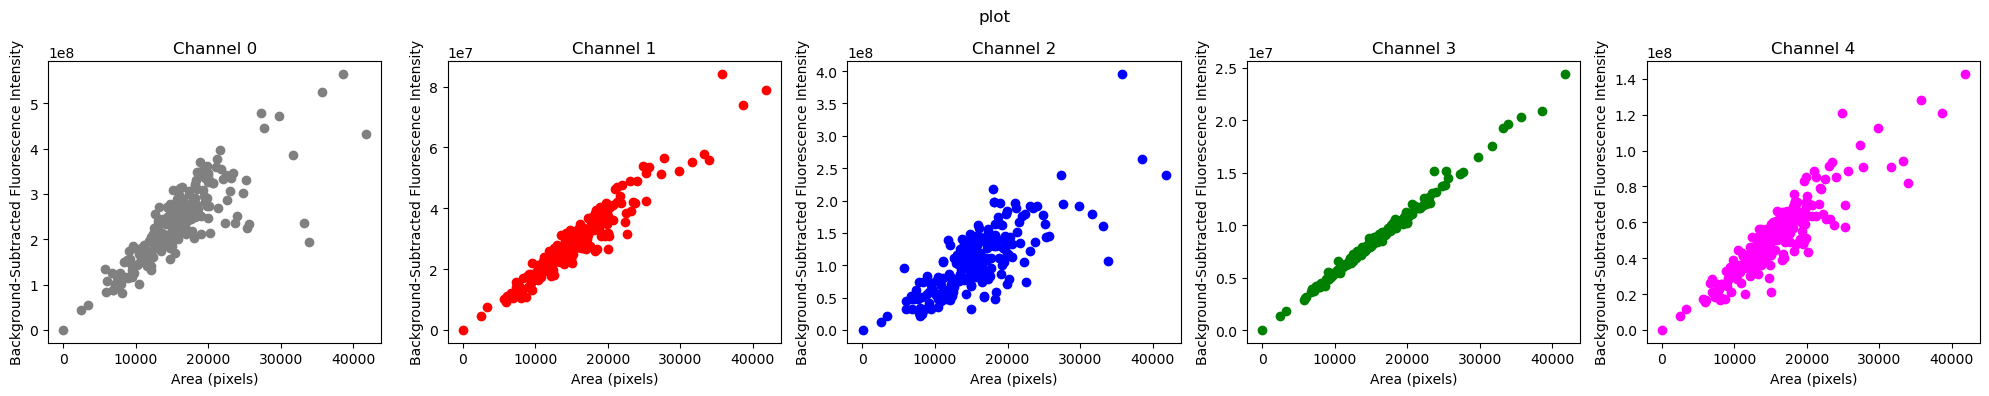

In [8]:
make_plot_vs_area(neg_df)

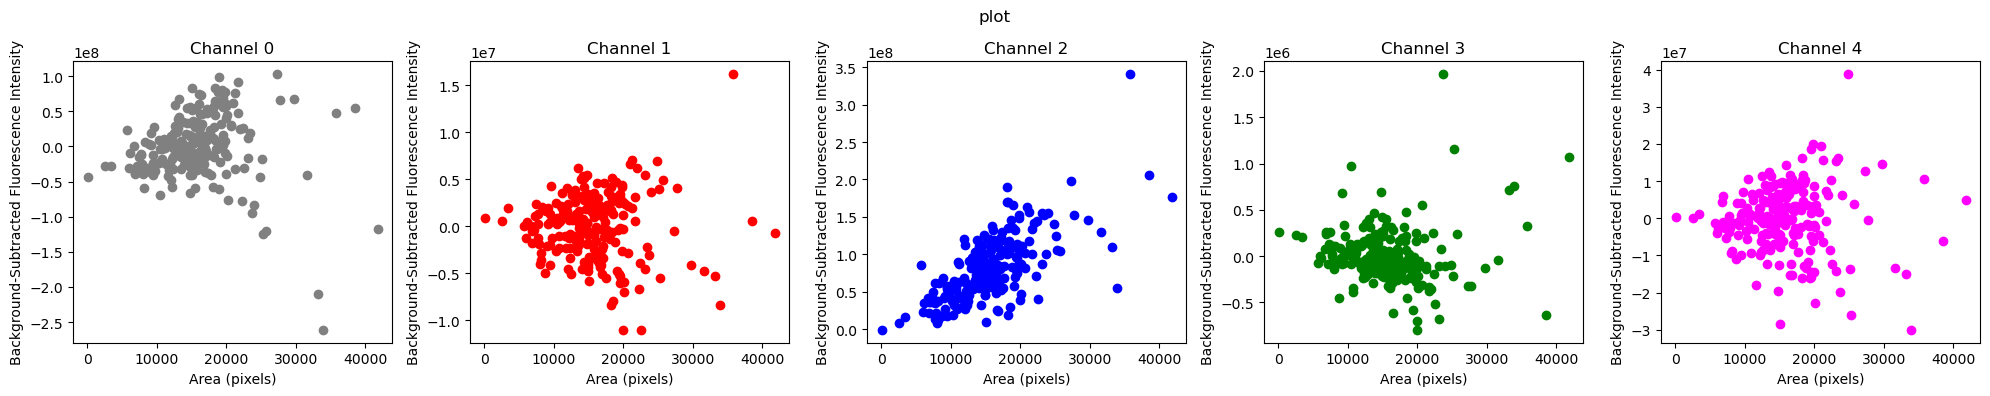

In [9]:
make_plot_vs_area(remove_background(neg_df, bg_df))

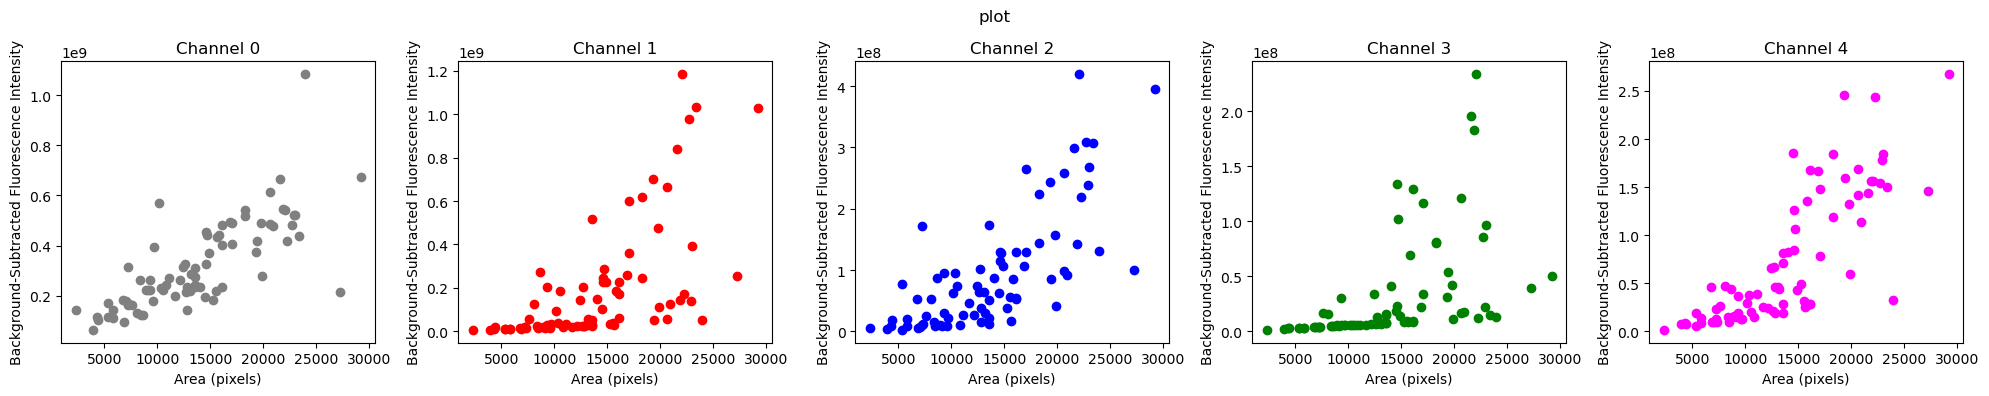

In [10]:
make_plot_vs_area(pos_df)

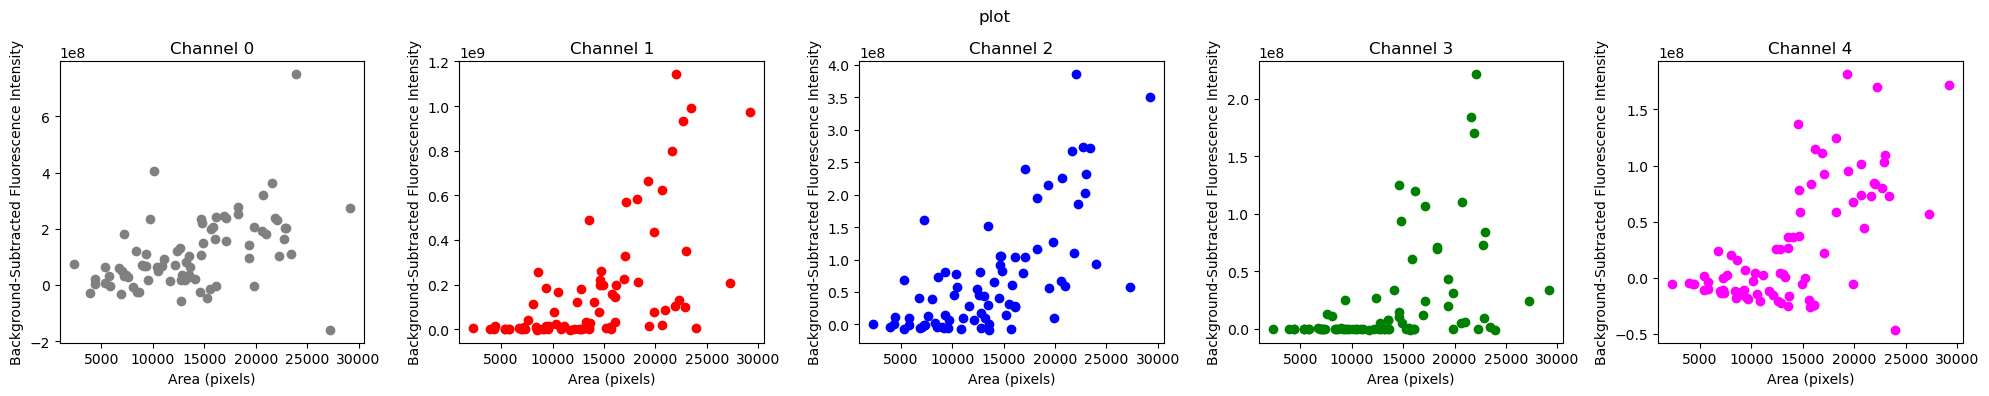

In [11]:
make_plot_vs_area(remove_background(pos_df, bg_df))

In [12]:
binarized_pos = binarize(remove_background(pos_df, bg_df), cutoffs)
binarized_pos

,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4,area_pixels_binarized,integrated_intensity_channel_0_binarized,integrated_intensity_channel_1_binarized,integrated_intensity_channel_2_binarized,integrated_intensity_channel_3_binarized,integrated_intensity_channel_4_binarized
label,,,,,,,,,,,,
1,5796.0,-3.419203e+06,1.177463e+06,10055144.0,1.052504e+05,-4.278616e+06,0,0,0,0,0,0
2,22255.0,1.034653e+08,1.307365e+08,185528250.0,-2.386083e+05,1.702632e+08,0,0,1,1,0,1
3,20609.0,1.937670e+08,1.712955e+07,66726322.0,5.399272e+06,7.362223e+07,0,0,0,1,0,1
4,13110.0,1.662564e+07,2.974204e+06,43461191.0,-4.661837e+05,3.293207e+06,0,0,0,0,0,0
5,6727.0,6.007093e+07,4.174554e+06,41205187.0,5.566970e+05,2.388897e+07,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75,16903.0,2.448178e+08,2.260283e+08,79848959.0,1.229713e+07,1.112624e+08,0,0,1,1,0,1
76,4344.0,2.067132e+07,2.047311e+06,1035409.0,3.014332e+05,-5.247107e+06,0,0,0,0,0,0
77,5776.0,3.104499e+07,-2.916419e+03,-877763.0,-8.298252e+04,-1.010663e+07,0,0,0,0,0,0


In [13]:
binarized_pos.mean()

area_pixels                                 1.372337e+04
integrated_intensity_channel_0              1.105444e+08
integrated_intensity_channel_1              1.645366e+08
integrated_intensity_channel_2              7.325200e+07
integrated_intensity_channel_3              2.360508e+07
integrated_intensity_channel_4              2.804499e+07
area_pixels_binarized                       0.000000e+00
integrated_intensity_channel_0_binarized    3.797468e-02
integrated_intensity_channel_1_binarized    5.189873e-01
integrated_intensity_channel_2_binarized    4.810127e-01
integrated_intensity_channel_3_binarized    2.784810e-01
integrated_intensity_channel_4_binarized    4.303797e-01
dtype: float64

In [14]:
binarize(remove_background(neg_df, bg_df), cutoffs).mean()

area_pixels                                 1.571825e+04
integrated_intensity_channel_0              3.312122e-08
integrated_intensity_channel_1             -5.418604e-10
integrated_intensity_channel_2              8.336420e+07
integrated_intensity_channel_3             -4.013154e-09
integrated_intensity_channel_4             -2.059070e-08
area_pixels_binarized                       0.000000e+00
integrated_intensity_channel_0_binarized    0.000000e+00
integrated_intensity_channel_1_binarized    0.000000e+00
integrated_intensity_channel_2_binarized    7.818182e-01
integrated_intensity_channel_3_binarized    0.000000e+00
integrated_intensity_channel_4_binarized    4.545455e-03
dtype: float64

In [15]:
file_names = []
binarized_means = []

results_folder = os.path.join(image_folder,'binarized_results')
os.makedirs(results_folder, exist_ok=True)

for file in os.listdir(image_folder):
    if file.endswith('.csv'):
        img_df = pd.read_csv(os.path.join(image_folder,file), index_col=0)
        binarized_df = binarize(remove_background(img_df, bg_df), cutoffs)
        binarized_df.to_csv(os.path.join(results_folder,file)+"_binarized.csv") #save results
        binarized_means.append(binarized_df.mean())
        file_names.append(file.split('.')[0])

In [16]:
file_names

['Day14_F3_1',
 'Day15_F3_2',
 'Day11_F2_1',
 'Day9_F3_2',
 'Day15_PGP1_1',
 'Day1_F3_2',
 'Day5_F2_1',
 'Day4_F2_2',
 'Day14_PGP1_1_nice_overlap',
 'iPSC_PGP1_1',
 'Day9_PGP1_2_hazy_overlap',
 'Day13_PGP1_2',
 'Day10_PGP1_1',
 'Day3_PGP1_2',
 'Day10_F2_1_hazy_overlap',
 'iPSC_F2_2',
 'Day7_F2_1_onecell_hazyoverlap',
 'Day12_F2_3_someoverlap',
 'Day6_F3_2',
 'Day7_F3_1',
 'Day3_F2_2',
 'Day2_F2_1',
 'Day5_PGP1_1',
 'Day12_F3_2',
 'Day7_F3_2_hazy_overlap',
 'Day13_PGP1_3',
 'Day8_PGP1_2_niceoverlap',
 'Day13_F2_1',
 'Day9_PGP1_1_overlap',
 'Day12_PGP1_2',
 'Day8_F3_2_overlap',
 'Day3_F3_2',
 'Day2_F3_1',
 'Day6_F3_1_onecell_hazyoverlap',
 'Day7_F2_2_onecell_hazyoverlap',
 'Day9_F2_1_hazy_overlap',
 'iPSC_F3_2',
 'Day4_PGP1_1',
 'Day13_F2_1_lowerexpose',
 'Day10_PGP1_2_nice_overlap',
 'Day6_F2_2_onecell_hazyoverlap',
 'Day8_F3_1_overlap',
 'Day2_PGP1_2',
 'Day5_F3_1',
 'Day9_F2_2_nice_overlap',
 'Day4_F3_2',
 'Day14_PGP1_2_nice_overlap',
 'Day1_F2_2',
 'Day14_F2_1',
 'Day1_PGP1_1',
 'Day

In [17]:
binarized_means

[area_pixels                                 1.698896e+04
 integrated_intensity_channel_0             -1.223301e+07
 integrated_intensity_channel_1              4.094982e+07
 integrated_intensity_channel_2              2.962162e+07
 integrated_intensity_channel_3              6.171115e+06
 integrated_intensity_channel_4             -1.234412e+07
 area_pixels_binarized                       0.000000e+00
 integrated_intensity_channel_0_binarized    0.000000e+00
 integrated_intensity_channel_1_binarized    2.289157e-01
 integrated_intensity_channel_2_binarized    2.530120e-01
 integrated_intensity_channel_3_binarized    8.433735e-02
 integrated_intensity_channel_4_binarized    1.204819e-01
 dtype: float64,
 area_pixels                                 1.275059e+04
 integrated_intensity_channel_0              5.752140e+07
 integrated_intensity_channel_1              8.614139e+07
 integrated_intensity_channel_2              4.215113e+07
 integrated_intensity_channel_3              8.274795e+

In [18]:
summary_df = pd.DataFrame(binarized_means, index=file_names)
summary_df.insert(0, "Cells", [name.split('_')[1] for name in file_names]) #Add the well information based on the file name
summary_df.insert(0, "Day", [name.split('_')[0] for name in file_names]) #Add the well information based on the file name
summary_df.index.name = "File"
summary_df.sort_index(inplace=True)
summary_df.to_csv("2024-05-04_timecourse_stainB_stats.csv")
summary_df
#pd.concat(binarized_means, axis = 1)

,Day,Cells,area_pixels,integrated_intensity_channel_0,integrated_intensity_channel_1,integrated_intensity_channel_2,integrated_intensity_channel_3,integrated_intensity_channel_4,area_pixels_binarized,integrated_intensity_channel_0_binarized,integrated_intensity_channel_1_binarized,integrated_intensity_channel_2_binarized,integrated_intensity_channel_3_binarized,integrated_intensity_channel_4_binarized
File,,,,,,,,,,,,,,
Day10_F2_1_hazy_overlap,Day10,F2,13764.385965,8.829541e+06,2.475846e+07,3.599206e+07,8.017617e+06,-2.310027e+06,0.0,0.0,0.140351,0.289474,0.078947,0.149123
Day10_F2_2_overlap,Day10,F2,12748.828571,1.914946e+07,1.921702e+07,3.452110e+07,6.403663e+06,-8.203760e+04,0.0,0.0,0.150000,0.257143,0.057143,0.157143
Day10_F3_1_overlap,Day10,F3,13434.841346,4.354091e+07,3.760470e+07,2.797574e+07,4.786259e+06,-4.718904e+06,0.0,0.0,0.230769,0.211538,0.028846,0.139423
Day10_F3_2_overlap,Day10,F3,14556.288462,2.766547e+07,2.450856e+07,3.354527e+07,4.957610e+06,-7.203957e+06,0.0,0.0,0.177885,0.264423,0.033654,0.120192
Day10_PGP1_1,Day10,PGP1,13896.008621,6.831533e+07,5.144166e+07,3.429341e+07,9.165011e+06,5.424694e+06,0.0,0.0,0.331897,0.288793,0.073276,0.237069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iPSC_F2_2,iPSC,F2,21499.233645,1.653488e+06,2.471628e+05,1.378951e+08,1.942204e+04,8.202842e+06,0.0,0.0,0.000000,0.887850,0.000000,0.121495
iPSC_F3_1,iPSC,F3,16446.711765,-5.517226e+06,5.835073e+06,1.015710e+08,-1.042256e+05,3.899752e+06,0.0,0.0,0.000000,0.894118,0.000000,0.041176
iPSC_F3_2,iPSC,F3,16340.735849,-1.388804e+07,6.663051e+06,8.387661e+07,2.297451e+05,5.517949e+06,0.0,0.0,0.018868,0.823899,0.000000,0.037736


# plot the results

In [19]:
formatted_df = pd.read_csv("2024-05-04_timecourse_stainB_stats_formatted.csv", index_col=0, keep_default_na=False )
formatted_df

,Day,Cells,SYCP3,KI67,TEX12,RAD51
File,,,,,,
Day10_F2_1_hazy_overlap,10,F2,0.140351,0.289474,0.078947,0.149123
Day10_F2_2_overlap,10,F2,0.150000,0.257143,0.057143,0.157143
Day10_F3_1_overlap,10,F3,0.230769,0.211538,0.028846,0.139423
Day10_F3_2_overlap,10,F3,0.177885,0.264423,0.033654,0.120192
Day10_PGP1_1,10,PGP1,0.331897,0.288793,0.073276,0.237069
...,...,...,...,...,...,...
iPSC_F2_2,0,F2,0.000000,0.887850,0.000000,0.000000
iPSC_F3_1,0,F3,0.000000,0.894118,0.000000,0.041176
iPSC_F3_2,0,F3,0.018868,0.823899,0.000000,0.037736


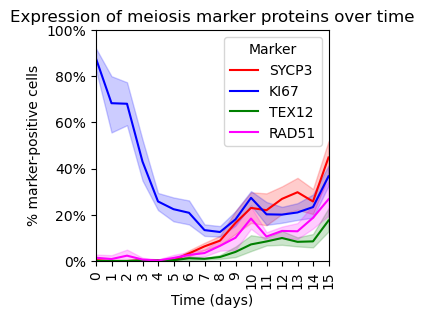

In [20]:
from matplotlib.ticker import FuncFormatter

def percent_format(x, pos):
    return '{:.0f}%'.format(x * 100)

melted_df = pd.melt(formatted_df[["Day","SYCP3","KI67","TEX12","RAD51"]], id_vars='Day', var_name='Marker', value_name='Value')
melted_df
plt.figure(figsize=(3, 3))
sns.lineplot(data=melted_df, x='Day', y='Value', hue='Marker', palette = ["red","blue","green","magenta"])#palette = ["blue","gold","green","red"])
sns.move_legend(plt.gca(), "upper right")
plt.title('Expression of meiosis marker proteins over time')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,1)
plt.xlim(0,15)
plt.ylabel('% marker-positive cells')
plt.xlabel('Time (days)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))  # Apply custom formatter
#plt.show()
plt.savefig("2024-05-04_timecourse_stainB_smaller.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-04_timecourse_stainB_smaller.svg",bbox_inches="tight")

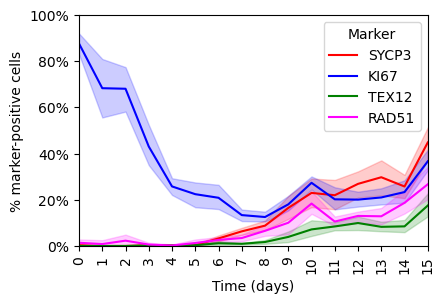

In [26]:
plt.figure(figsize=(4.5, 3))
sns.lineplot(data=melted_df, x='Day', y='Value', hue='Marker', palette = ["red","blue","green","magenta"])#palette = ["blue","gold","green","red"])
sns.move_legend(plt.gca(), "upper right")
plt.title('')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,1)
plt.xlim(0,15)
plt.ylabel('% marker-positive cells')
plt.xlabel('Time (days)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))  # Apply custom formatter
#plt.show()
plt.savefig("2024-05-24_timecourse_stainB_smaller.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-24_timecourse_stainB_smaller.svg",bbox_inches="tight")

In [22]:
#Also plot cell growth
growth_df = pd.read_csv("/Users/merrickpiersonsmela/Documents/Church_Lab/oogenesis/Meiosis Manuscript Writing/Figures/cell_growth_15days.csv")
growth_df

,Cells,Day,Live cells per cm2
0,F2,0,55400.00000
1,F2,1,121184.21050
2,F2,2,202105.26320
3,F2,3,307894.73680
4,F2,4,317105.26320
5,F2,5,364473.68420
6,F2,6,411842.10530
7,F2,7,402631.57890
8,F2,8,464473.68420
9,F2,9,398684.21050


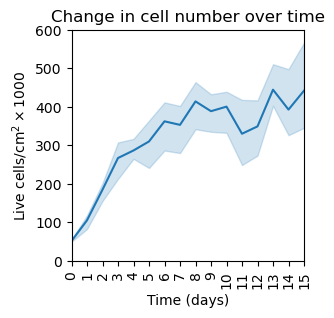

In [23]:
plt.figure(figsize=(3, 3))
sns.lineplot(data=growth_df, x='Day', y=growth_df['Live cells per cm2']/1000)#palette = ["blue","gold","green","red"])
plt.title('Change in cell number over time')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,600)
plt.xlim(0,15)
plt.ylabel('Live cells/cm$^2 \\times 1000$')
plt.xlabel('Time (days)')
plt.savefig("2024-05-04_timecourse_growth_smaller.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-04_timecourse_growth_smaller.svg",bbox_inches="tight")

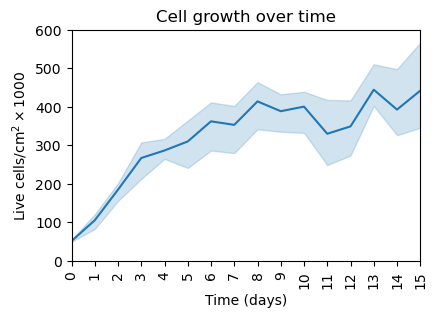

In [27]:
plt.figure(figsize=(4.5, 3))
sns.lineplot(data=growth_df, x='Day', y=growth_df['Live cells per cm2']/1000)#palette = ["blue","gold","green","red"])
plt.title('Cell growth over time')
#plt.xlabel('Combinations of factors')
plt.xticks(np.arange(0,16), rotation=90)
plt.ylim(0,600)
plt.xlim(0,15)
plt.ylabel('Live cells/cm$^2 \\times 1000$')
plt.xlabel('Time (days)')
plt.savefig("2024-05-24_timecourse_growth_smaller.png",dpi=256,bbox_inches="tight")
plt.savefig("2024-05-24_timecourse_growth_smaller.svg",bbox_inches="tight")